In [1]:
import sys
from pathlib import Path

path = Path().resolve()
if path.name == "demos":
    sys.path.append(str(path.parent))

In [2]:
from collections import deque
from typing import Optional, Sequence

import numpy as np
from ipywidgets import IntSlider, interact, interact_manual

# Matplotlib helppers

Implement functions `imshow` and `dctshow` to help with the visualization of the following code

In [3]:
# matplotlib helppers

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.axes import Axes
from matplotlib.colors import CenteredNorm, LogNorm, SymLogNorm


def imshow(*imgs):
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 5, 5))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for ax, img in zip(axes, imgs):
        ax.axis("off")
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)

    return fig, axes


def dctshow(*imgs, show_texts: bool | Sequence[bool] = False):
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 5, 5))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    if not isinstance(show_texts, Sequence):
        show_texts = [show_texts] * len(imgs)

    max_val = np.max(np.abs(imgs))
    norm = SymLogNorm(1, base=2, vmax=max_val, vmin=-max_val)
    for ax, img, txt in zip(axes, imgs, show_texts):
        height, width = img.shape

        ax.axis("off")
        cm = ax.imshow(img, cmap="PiYG", norm=norm)
        fig.colorbar(cm)

        if not txt:
            continue

        max_bitplanes = np.frexp(img)[1] * np.sign(img)
        for (i, j), val in np.ndenumerate(max_bitplanes):
            ax.text(
                j, i, val, 
                ha="center", 
                va="center", 
                fontweight='bold', 
                color=(0.2, 0.2, 0.2),
            )  # fmt: skip

        # I could not think in anything better =(
        def draw_h_grid(a, b, w):
            if (b - a) <= 1:
                return
            half = (a + b) // 2
            ax.hlines(half - 0.5, xmin=-0.5, xmax=width - 0.5, linewidth=w, color="grey")
            draw_h_grid(a, half, w * 0.6)
            draw_h_grid(half, b, w * 0.6)

        def draw_v_grid(a, b, w):
            if (b - a) <= 1:
                return
            half = (a + b) // 2
            ax.vlines(half - 0.5, ymin=-0.5, ymax=height - 0.5, linewidth=w, color="grey")
            draw_v_grid(a, half, w * 0.6)
            draw_v_grid(half, b, w * 0.6)

        draw_h_grid(0, height, 2)
        draw_v_grid(0, width, 2)

    return fig, axes

# Importa uma imagem

Disponivel [aqui](https://www.hlevkin.com/hlevkin/06testimages.htm)

(787, 576)

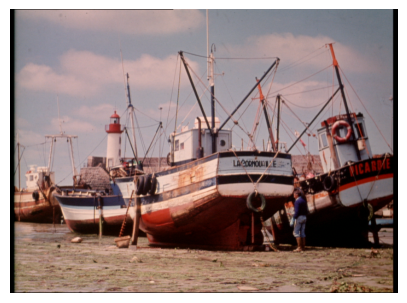

In [4]:
from PIL import Image

image = Image.open("../datasets/images/boats.ppm")
imshow(image)
image.size

# Simplifica a imagem

Para facilitar o exemplo vamos diminuir a resolução, cortar as bordas, e pegar apenas um dos canais de cores

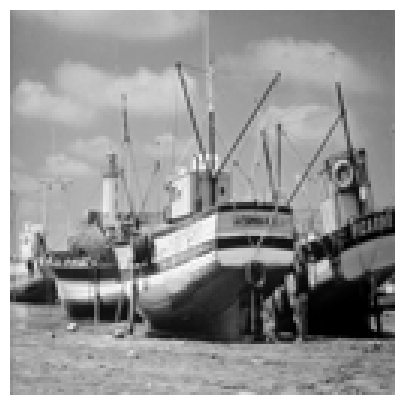

In [5]:
w, h = 128, 128
border = 2
small_image = image.resize((w + border * 2, h + border * 2)).crop((border, border, w + border, h + border)).getchannel(0)
imshow(small_image)
array = np.array(small_image)

In [6]:
block = array

@interact
def select_block(size=[8, 16, 32, 64], x=(0, array.shape[1]), y=(0, array.shape[0])):
    global block
    height, width = array.shape

    x = np.clip(x, 0, width - size - 1)
    y = np.clip(y, 0, height - size - 1)

    block = array[
        y : y + size,
        x : x + size,
    ]
    fig, axes = imshow(array, block)

    rect = patches.Rectangle((x, y), size, size, fill=False, color="red", linewidth=4)
    axes[0].add_patch(rect)

    rect = patches.Rectangle((-0.5, -0.5), size, size, fill=False, color="red", linewidth=10)
    axes[1].add_patch(rect)

interactive(children=(Dropdown(description='size', options=(8, 16, 32, 64), value=8), IntSlider(value=64, desc…

In [7]:
from scipy.fft import dctn, idctn

transformed = dctn(block, norm="ortho").astype(int)
quantized = transformed


@interact_manual.options(manual_name="Execute DCT")(lower_bp=(0, 16))
def dct_and_quantization(lower_bp=0, show_bitplanes=False):
    global transformed, quantized

    transformed = dctn(block, norm="ortho").astype(int)
    quantized = np.sign(transformed) * (np.abs(transformed) >> lower_bp)
    dctshow(transformed, quantized, show_texts=show_bitplanes)

    recovered = idctn(quantized << lower_bp, norm="ortho")
    imshow(block, recovered)

interactive(children=(IntSlider(value=0, description='lower_bp', max=16), Checkbox(value=False, description='s…

# Function helppers to visualize the MuLE encoding

In [8]:
from itertools import chain, pairwise, product
from typing import Generator


def split_shape_in_half(_slices: tuple[int] | tuple[slice]) -> Generator[slice, None, None]:
    if len(_slices) == 0:
        raise StopIteration()

    if isinstance(_slices[0], int):
        _slices = bigger_possible_slice(_slices)

    slices_per_dimension = []
    for _slice in _slices:
        half = _slice.start + (_slice.stop - _slice.start) // 2

        if half == 0:
            slices = (slice(_slice.start, _slice.stop),)
        else:
            slices = (slice(_slice.start, half), slice(half, _slice.stop))

        slices_per_dimension.append(slices)

    for slices in product(*slices_per_dimension):
        yield slices


def split_blocks_in_half(block: np.ndarray) -> Generator[np.ndarray, None, None]:
    for slices in split_shape_in_half(block.shape):
        yield block[slices]


def bigger_possible_slice(shape: tuple[int]) -> tuple[slice]:
    return tuple(slice(0, size) for size in shape)


def plot_mule(flags: Sequence[str], image: np.ndarray):
    slices = bigger_possible_slice(image.shape)
    max_bitplane = int(image.size * 255).bit_length()

    fig, axes = dctshow(image, image, show_texts=[False, True])
    bits = recursive_plot_mule(deque(flags), slices, max_bitplane, image, ax=axes[0])

    print("Number of Bits:", bits)
    plt.show()


def lossless_mule_optimization(image: np.ndarray, bitplane: int) -> str:
    if image.size == 0:
        return ""

    if image.size == 1:
        return ""

    if not np.any(image):
        return "Z"

    max_bitplane = int(np.max(np.abs(image))).bit_length()
    if max_bitplane < bitplane:
        return "L" + lossless_mule_optimization(image, bitplane - 1)

    flags = "S"
    for sub_block in split_blocks_in_half(image):
        flags += lossless_mule_optimization(sub_block, bitplane)
    return flags


def recursive_plot_mule(
    flags: deque[str],
    position: tuple[slice],
    bitplane: int,
    image: np.ndarray,
    ax: Optional[Axes] = None,
    transparency=0.3,
):
    start = tuple(s.start - 0.5 for s in reversed(position))
    lengths = tuple(s.stop - s.start for s in reversed(position))
    size = np.prod(lengths)

    if ax is None:
        ax = plt.gca()

    # Show how it was divided
    rec = patches.Rectangle(
        start,
        *lengths,
        linewidth=2,
        edgecolor="midnightblue",
        fill=False,
    )
    ax.add_patch(rec)

    if size == 0:
        return

    if size == 1:
        ax.text(
            start[0] + lengths[0] / 2,
            start[1] + lengths[1] / 2,
            f"{bitplane}\nbits",
            ha="center",
            va="center",
            color="midnightblue",
            fontweight="bold",
            fontsize=8,
        )
        return bitplane

    if not flags:
        rec = patches.Rectangle(
            start,
            *lengths,
            linewidth=2,
            edgecolor="red",
            facecolor=("red", 0.2),
        )
        ax.add_patch(rec)

        ax.text(
            start[0] + lengths[0] / 2,
            start[1] + lengths[1] / 2,
            f"{bitplane}\nbits",
            ha="center",
            va="center",
            color="red",
            fontweight="bold",
        )

        return 0

    flag = flags.popleft()

    if flag == "Z":
        rec = patches.Rectangle(
            start,
            *lengths,
            facecolor="midnightblue",
            alpha=0.8,
        )
        ax.add_patch(rec)

        ax.text(
            start[0] + lengths[0] / 2,
            start[1] + lengths[1] / 2,
            f"Z",
            ha="center",
            va="center",
            color="midnightblue",
            fontweight="bold",
        )

        return 0

    elif flag == "L":
        return recursive_plot_mule(
            flags,
            position,
            bitplane - 1,
            image,
            ax=ax,
            transparency=transparency,
        )

    elif flag == "S":
        bits = 0
        for sub_pos in split_shape_in_half(position):
            bits += recursive_plot_mule(
                flags,
                sub_pos,
                bitplane,
                image,
                ax=ax,
                transparency=transparency,
            )
        return bits

    else:
        print("INVALID FLAG:", flag)
        return 0


# Interactive MULE example

In [9]:
max_bitplane = int(quantized.size * 255).bit_length()
colinha = lossless_mule_optimization(quantized, max_bitplane)

print("Colinha:", colinha)
print()
print("Flag L:\t", len([f for f in colinha if f == "L"]))
print("Flag S:\t", len([f for f in colinha if f == "S"]))
print("Flag Z:\t", len([f for f in colinha if f == "Z"]))
print("Total:\t", len(colinha))

Colinha: LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSSLLLS

Flag L:	 49
Flag S:	 21
Flag Z:	 0
Total:	 70


In [10]:
@interact
def interactive_mule(flags = colinha):
    plot_mule(flags, quantized)

interactive(children=(Text(value='LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSSLLLS', des…

# Images to use in a slideshow

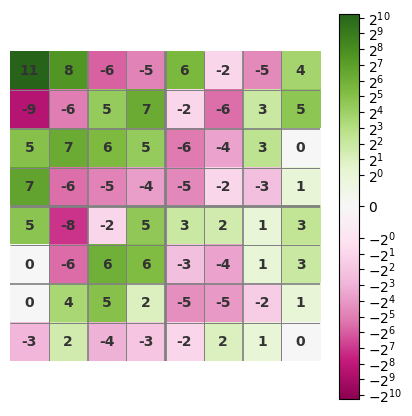

Flags:  


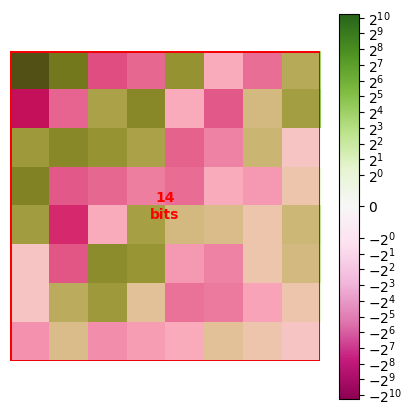

Flags:  LLL


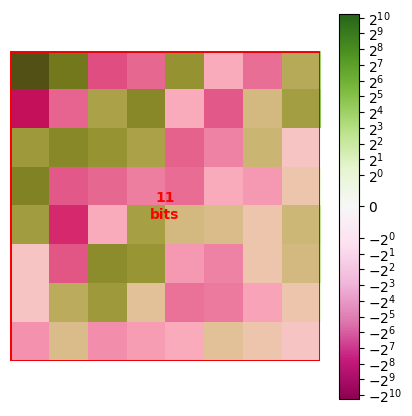

Flags:  LLLS


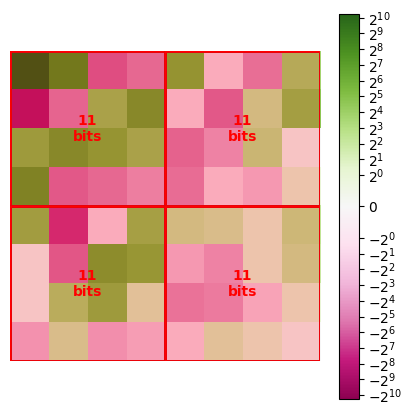

Flags:  LLLSS


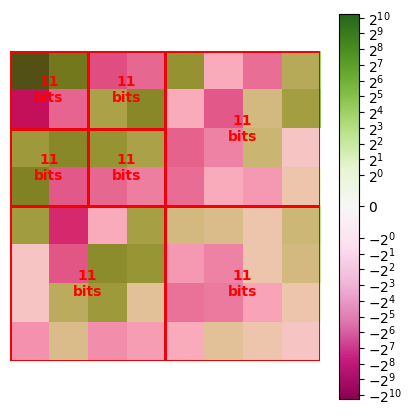

Flags:  LLLSSS


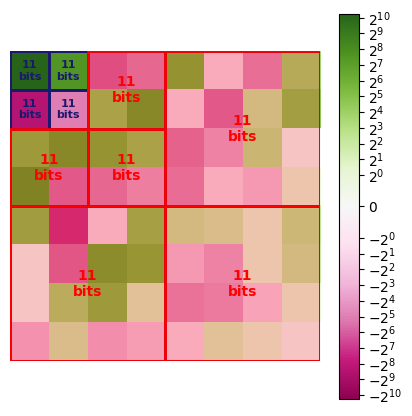

Flags:  LLLSSS


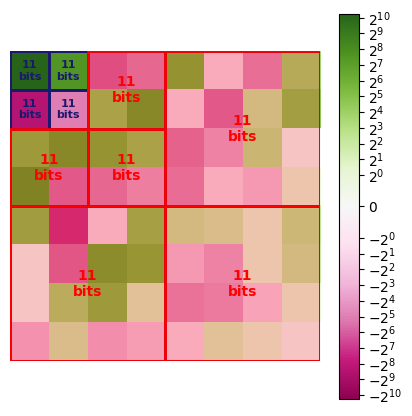

Flags:  LLLSSSLLLL


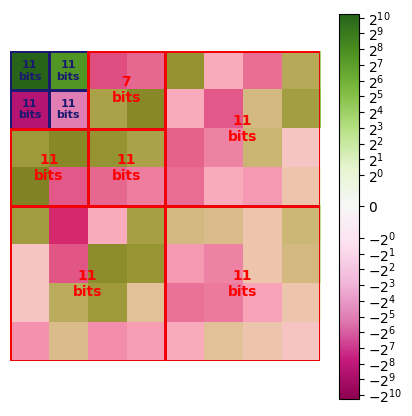

Flags:  LLLSSSLLLLS


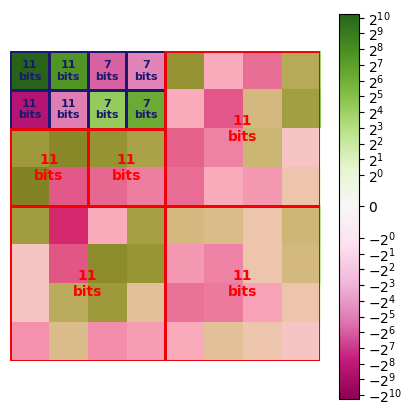

Flags:  LLLSSSLLLLS


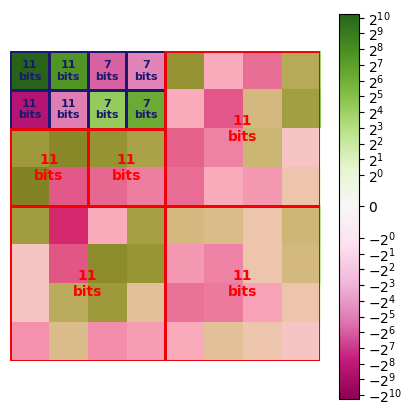

Flags:  LLLSSSLLLLSLLLL


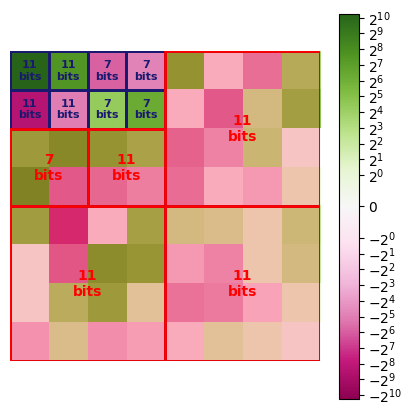

Flags:  LLLSSSLLLLSLLLLS


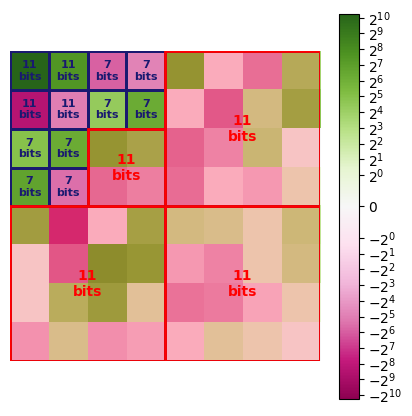

Flags:  LLLSSSLLLLSLLLLS


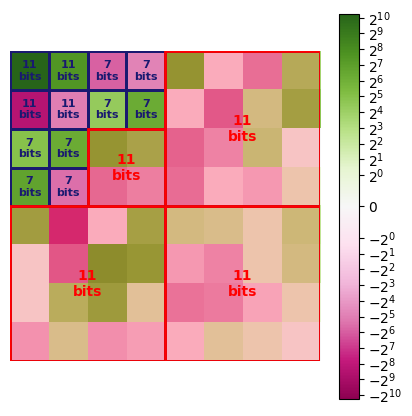

Flags:  LLLSSSLLLLSLLLLSLLLLL


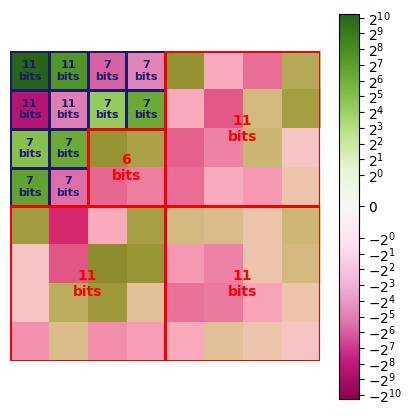

Flags:  LLLSSSLLLLSLLLLSLLLLLS


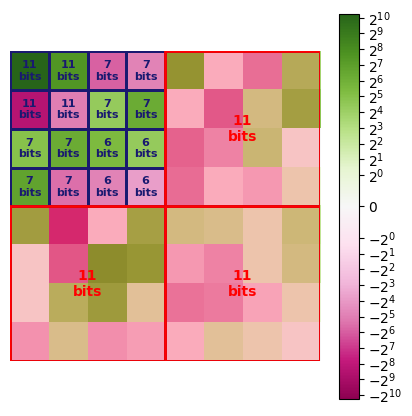

Flags:  LLLSSSLLLLSLLLLSLLLLLS


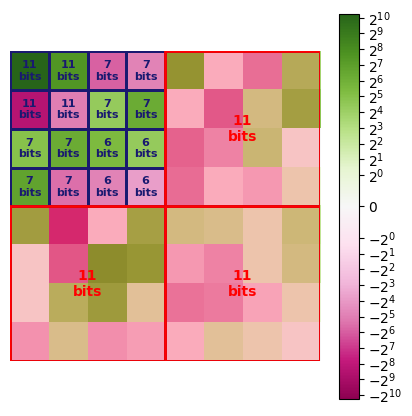

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLL


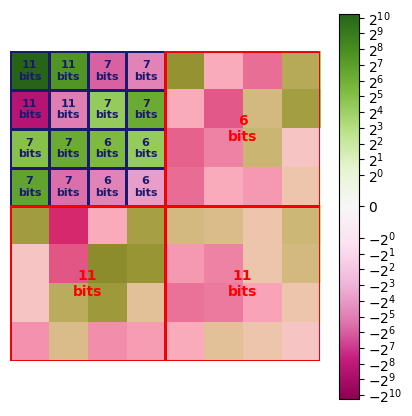

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLS


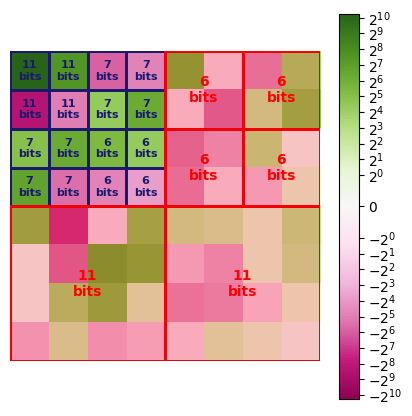

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSS


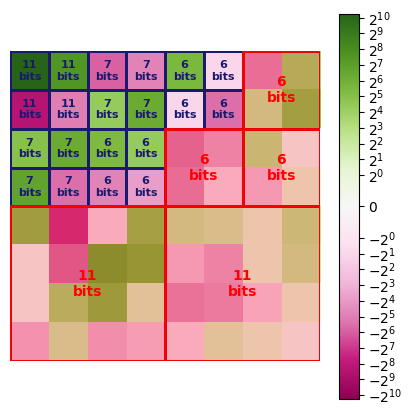

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSS


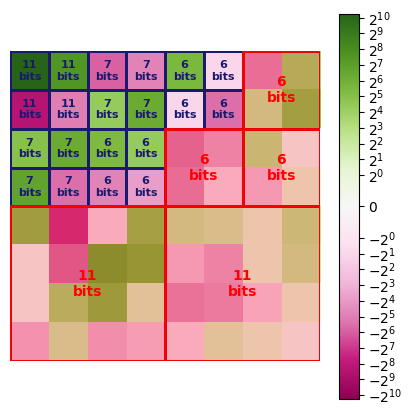

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSL


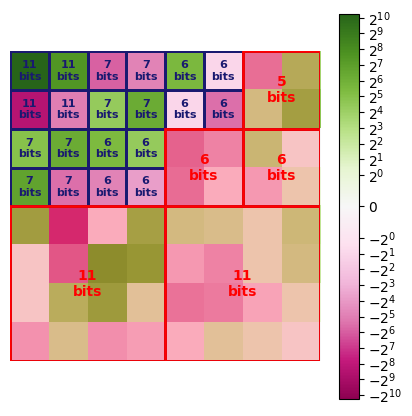

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLS


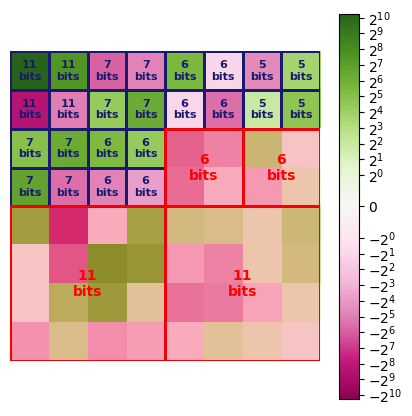

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSS


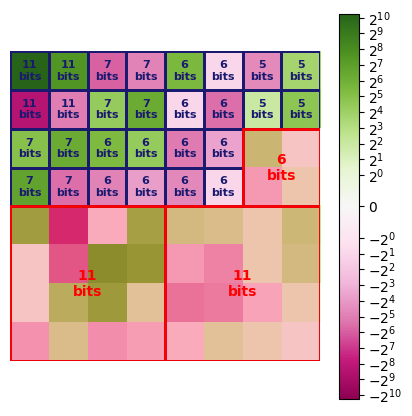

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSS


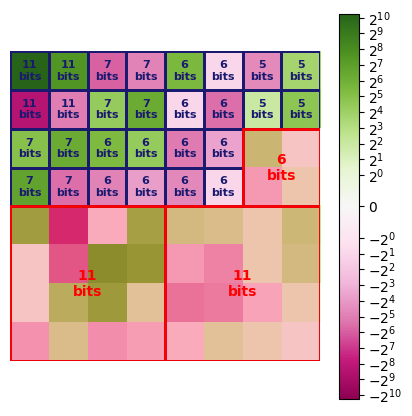

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLL


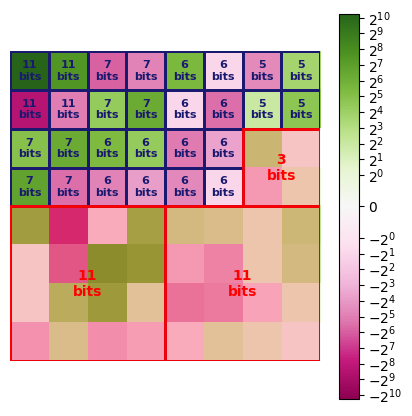

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLS


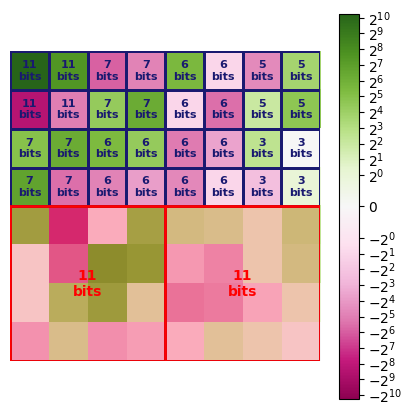

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLS


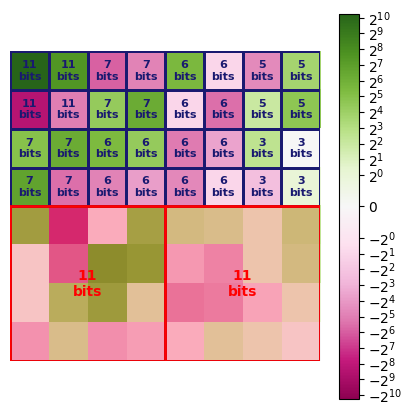

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLL


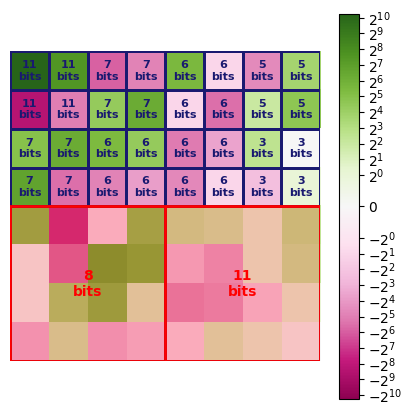

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLS


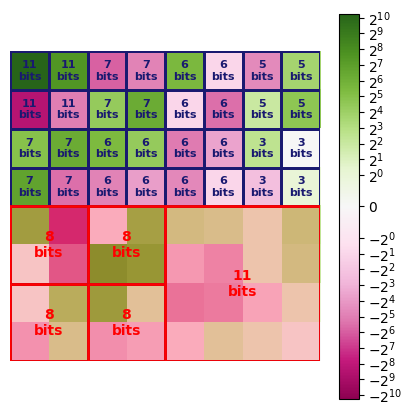

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSS


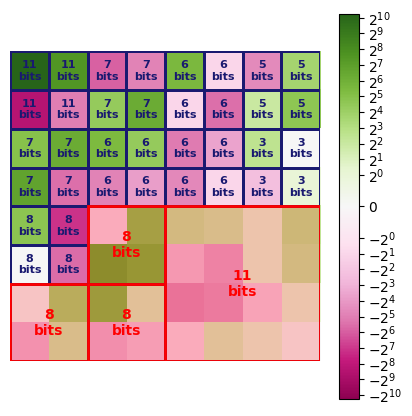

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSS


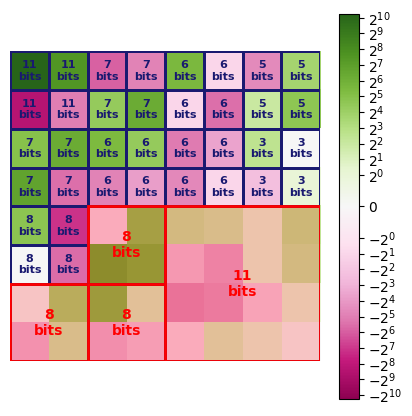

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLL


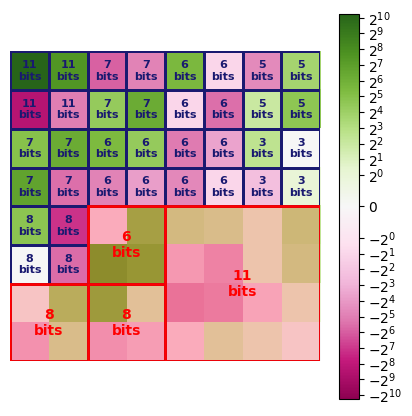

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLS


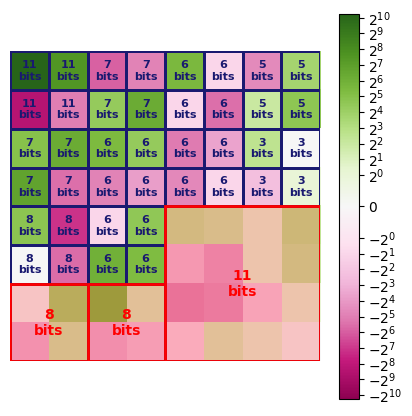

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLS


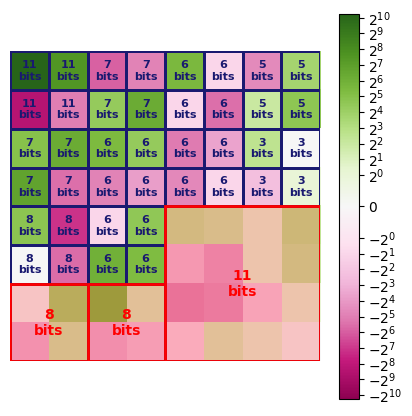

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLL


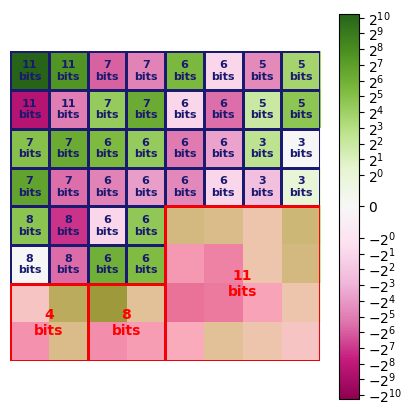

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLS


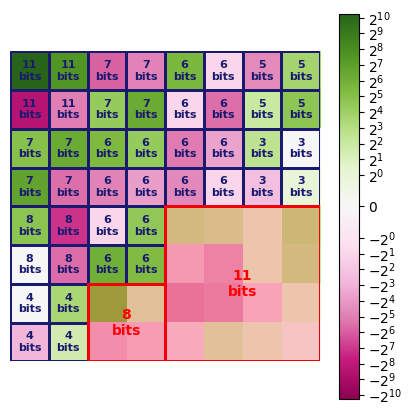

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLS


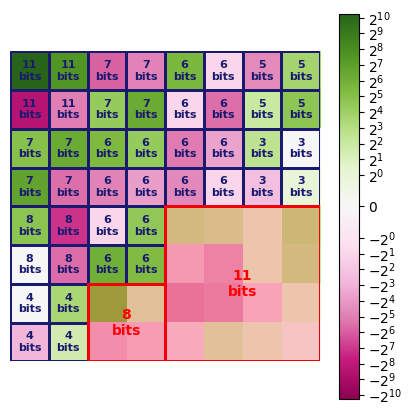

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLL


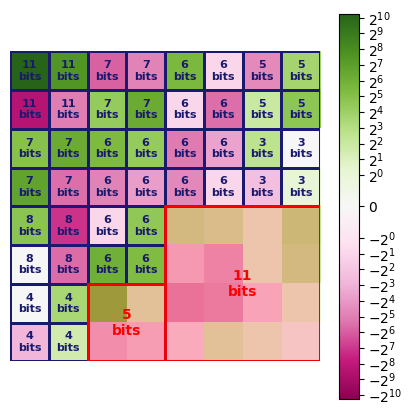

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLS


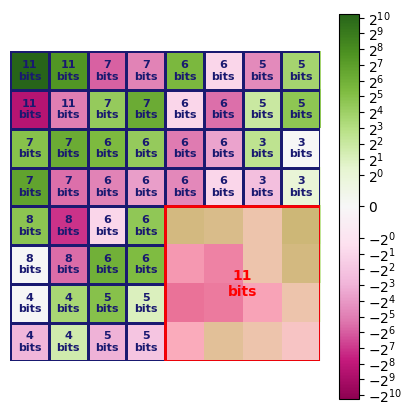

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLS


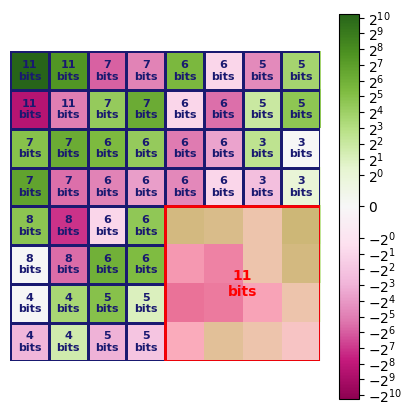

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLL


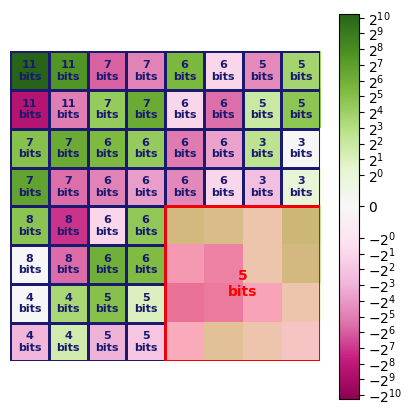

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLS


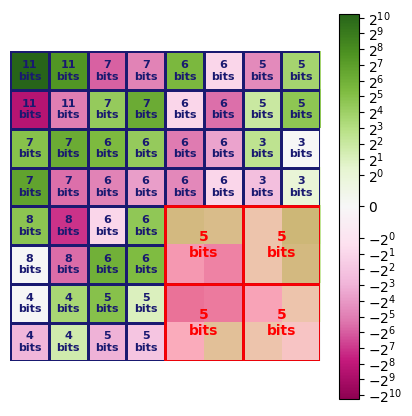

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLS


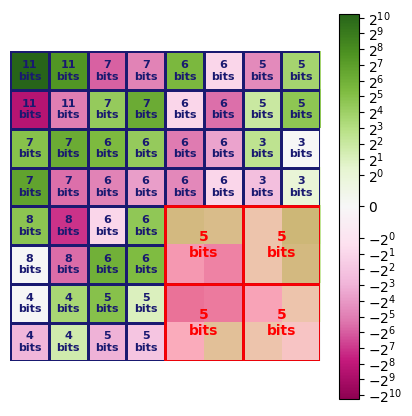

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSL


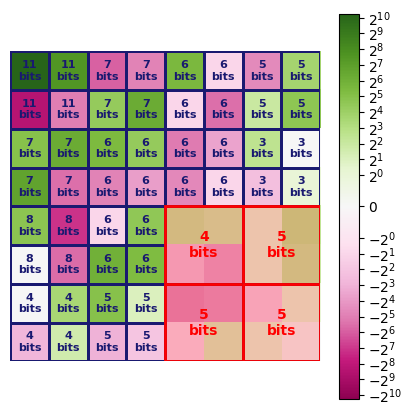

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLS


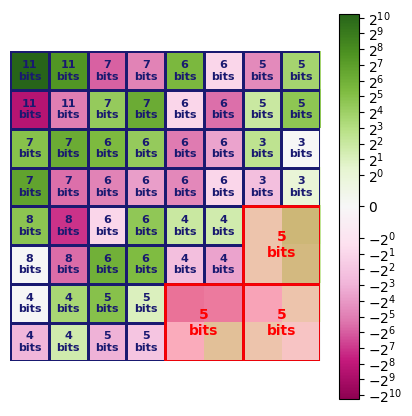

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLS


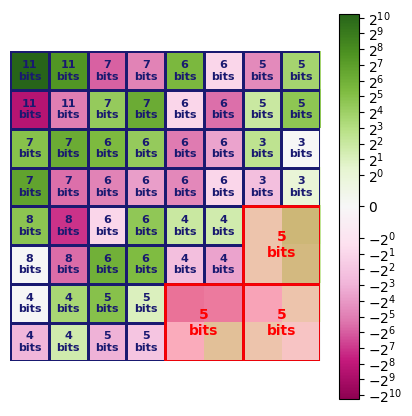

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLL


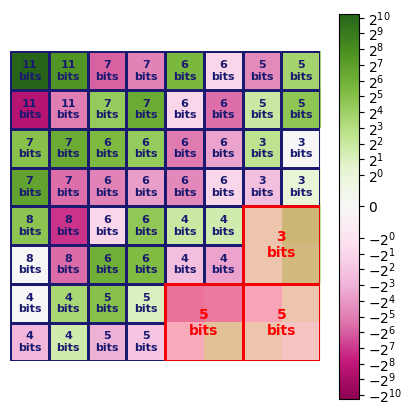

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLS


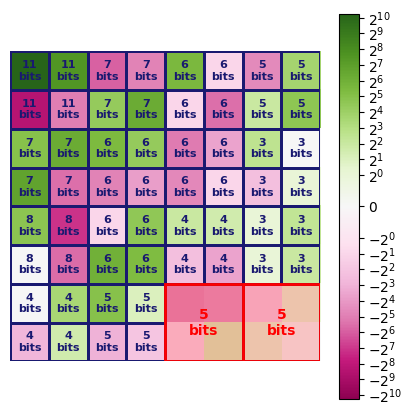

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSS


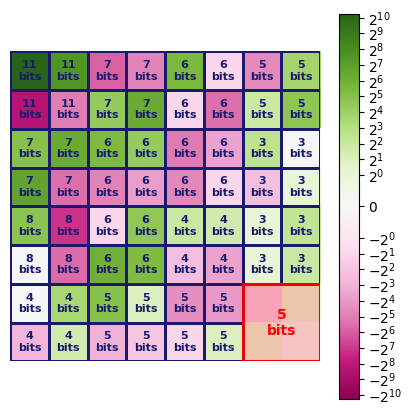

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSS


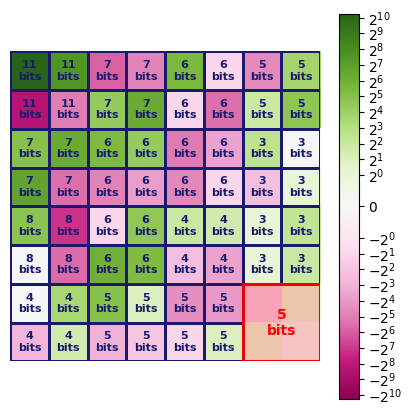

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSSLLL


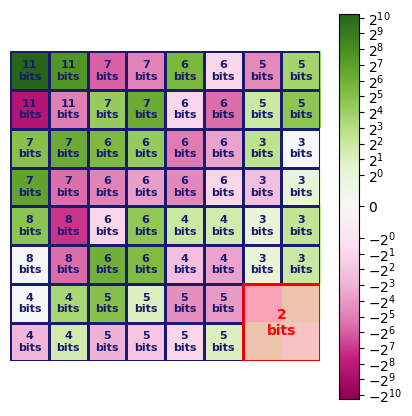

Flags:  LLLSSSLLLLSLLLLSLLLLLSLLLLLSSLSSLLLSLLLSSLLSLLLLSLLLSLLLLLLSLSLLSSLLLS


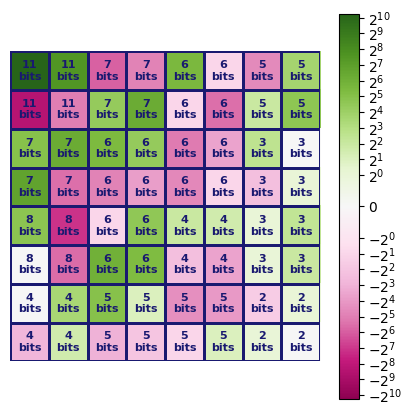

In [11]:
slices = bigger_possible_slice(quantized.shape)
max_bitplane = int(quantized.size * 255).bit_length()
flags = lossless_mule_optimization(quantized, max_bitplane)

lower_bps = 0
last_flag = None

fig, axes = dctshow(quantized, show_texts=True)
# plt.save("")
plt.show()

for i in range(len(flags)):
    flag = flags[i]

    if (flag != last_flag) and ("L" == flag or "L" == last_flag):
        print("Flags: ", flags[:i])
        fig, axes = dctshow(quantized)
        bits = recursive_plot_mule(
            deque(flags[:i]),
            slices,
            max_bitplane,
            quantized,
            ax=axes[0],
        )
        plt.show()

    if flag in ["S", "Z"]:
        print("Flags: ", flags[:i + 1])
        fig, axes = dctshow(quantized)
        bits = recursive_plot_mule(
            deque(flags[: i + 1]),
            slices,
            max_bitplane,
            quantized,
            ax=axes[0],
        )
        plt.show()

    last_flag = flag
